# Surface Circulation — NEMO GYRE

Analyse surface currents from the 2-year GYRE simulation.
- Surface current vectors
- Surface kinetic energy

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

OUTPUT_DIR = Path("../output")

ds_u = xr.open_dataset(
    OUTPUT_DIR / "GYRE_10d_00010101_00021230_grid_U_0000.nc", decode_times=False
)
ds_v = xr.open_dataset(
    OUTPUT_DIR / "GYRE_10d_00010101_00021230_grid_V_0000.nc", decode_times=False
)
ds_t = xr.open_dataset(
    OUTPUT_DIR / "GYRE_10d_00010101_00021230_grid_T_0000.nc", decode_times=False
)

# Surface level (index 0) time-mean velocities
u_sfc = ds_u["vozocrtx"].isel(depthu=0).mean("time_counter")
v_sfc = ds_v["vomecrty"].isel(depthv=0).mean("time_counter")

print(f"U shape: {u_sfc.shape}, V shape: {v_sfc.shape}")

U shape: (22, 32), V shape: (22, 32)


## Surface current vectors

Time-mean surface velocity field. The quiver plot should show the
double-gyre pattern: subtropical anticyclonic gyre in the south,
subpolar cyclonic gyre in the north, with a strong western boundary
current.

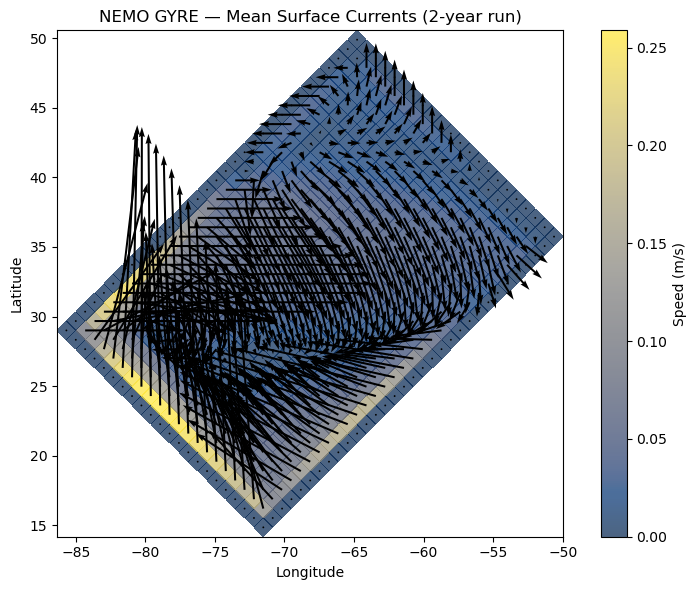

In [2]:
lon = ds_t.nav_lon.values
lat = ds_t.nav_lat.values

# U and V live on staggered grids; trim to the common interior
ny, nx = min(u_sfc.shape[0], v_sfc.shape[0]), min(u_sfc.shape[1], v_sfc.shape[1])
u = u_sfc.values[:ny, :nx]
v = v_sfc.values[:ny, :nx]
lo = lon[:ny, :nx]
la = lat[:ny, :nx]

speed = np.sqrt(u**2 + v**2)

fig, ax = plt.subplots(figsize=(8, 6))
pcm = ax.pcolormesh(lo, la, speed, shading="auto", cmap="cividis", alpha=0.7)
fig.colorbar(pcm, ax=ax, label="Speed (m/s)")

# Subsample for readable arrows
skip = 1
ax.quiver(
    lo[::skip, ::skip], la[::skip, ::skip],
    u[::skip, ::skip], v[::skip, ::skip],
    color="k", scale=0.5, width=0.004,
)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("NEMO GYRE — Mean Surface Currents (2-year run)")
ax.set_aspect("equal")
fig.tight_layout()

## Surface kinetic energy

Time-mean surface KE = 0.5 (u² + v²). Highlights the energetic
western boundary current and inter-gyre jet.

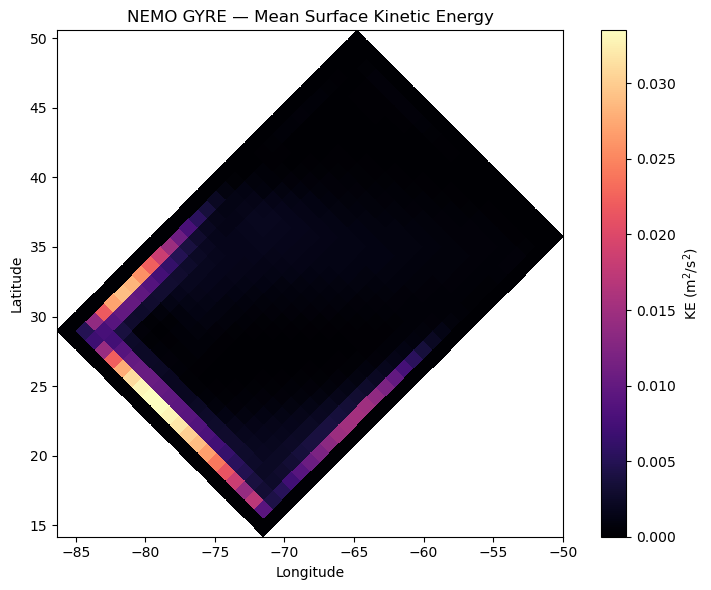

In [3]:
ke = 0.5 * speed**2

fig, ax = plt.subplots(figsize=(8, 6))
pcm = ax.pcolormesh(lo, la, ke, shading="auto", cmap="magma")
fig.colorbar(pcm, ax=ax, label="KE (m$^2$/s$^2$)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("NEMO GYRE — Mean Surface Kinetic Energy")
ax.set_aspect("equal")
fig.tight_layout()